# Plot vehicle volume at UK-Manchester
- This script is used to plot vehicle data from TfGM dataset.

In [1]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from staticmap import StaticMap, CircleMarker, Line
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import LinearSegmentedColormap, Normalize
import math
from PIL import Image
import matplotlib.gridspec as gridspec
home_path = '/gws/nopw/j04/duicv/yuansun/'

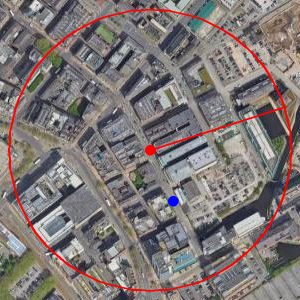

In [2]:
# Define latitude and longitude
lat_flux, lon_flux = 53.480821, -2.232823
lat_detect, lon_detect = 53.48017, -2.23233
radius_m = 200  # meters

# Create a static map object
m = StaticMap(300, 300, url_template="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}")
#m = StaticMap(800, 800, url_template="https://a.tile.openstreetmap.org/{z}/{x}/{y}.png")

# Add markers
m.add_marker(CircleMarker((lon_flux, lat_flux), "red", 10))  # Flux site
m.add_marker(CircleMarker((lon_detect, lat_detect), "blue", 10))  # Detection site

num_points = 100  # More points for a smoother circle
circle_points = []
for i in range(num_points):
    angle = 2 * math.pi * i / num_points  # Divide the circle into equal parts
    dlat = (radius_m / 111320) * math.cos(angle)  # Approximate conversion for latitude
    dlon = (radius_m / (111320 * math.cos(math.radians(lat_flux)))) * math.sin(angle)  # Longitude adjusts for latitude
    circle_points.append((lon_flux + dlon, lat_flux + dlat))
circle_points.append(circle_points[0])    
m.add_line(Line(circle_points, "red", 2))
m.add_line(Line([(lon_flux, lat_flux), circle_points[20]], "red", 2))

image = m.render()
image

In [3]:
proj = ccrs.PlateCarree()
fontsize = 8
labelsize = 6
labelcolor = '#6b6b6b'
radius_m=500
boundarywidth = 0.5
pad=2
xwidth=0.5
length=4
linewidth=0.5
lon_min, lon_max = -2.233, -2.232  # Longitude range
lat_min, lat_max = 53.48, 53.481  # Latitude range
title_list = ['(a) Observation sites', '(b) Diurnal traffic profile']
df_manchester = pd.read_csv(f'{home_path}0_urban_traffic/validation/manchester/aadt/UK-Manchester.csv')
df_manchester.head()

,UTC Datetime,vehicle_count,hour,date
0,2022-01-01 00:00:00,176.0,0,2022-01-01
1,2022-01-01 01:00:00,173.0,1,2022-01-01
2,2022-01-01 02:00:00,225.0,2,2022-01-01
3,2022-01-01 03:00:00,225.0,3,2022-01-01
4,2022-01-01 04:00:00,202.0,4,2022-01-01


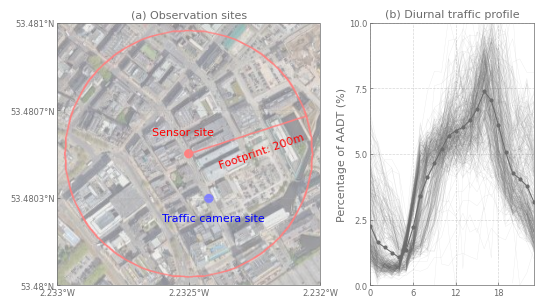

In [5]:
fig = plt.figure(figsize=(5.5, 3))
# Define gridspec to control subplot sizes
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], figure=fig)  # Adjust width ratio as needed

# Create subplots with custom widths
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())  # Wider
ax2 = fig.add_subplot(gs[1])
#ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree()) 
#ax2 = fig.add_subplot(1, 2, 2)
ax = [ax1, ax2]
ax1.imshow(image, extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), alpha=0.5)  # Set geo-coordinates
ax1.text(lon_flux+0.0003, lat_flux-0.00025, "Sensor site", fontsize=fontsize, color='red', ha="center", transform=proj)
ax1.text(lon_detect-0.000075, lat_detect+0.000075, "Traffic camera site", fontsize=fontsize, color='blue', ha="center", transform=proj)
ax1.text(lon_flux+0.0006, lat_flux-0.000375, f"Footprint: 200m", rotation=19,fontsize=fontsize, color='red', ha="center", transform=proj)

# Set labels and ticks
ax1.set_xticks(np.linspace(lon_min, lon_max, 3), crs=proj)
ax1.set_yticks(np.linspace(lat_min, lat_max, 4), crs=proj)
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=False))
ax1.tick_params(axis='both', which='both', left = True, right = False, labelleft=True, colors=labelcolor, labelsize=labelsize, 
               pad=pad, width=xwidth,length=length/2, direction='in')
diurnal_profiles = []
for date in np.unique(df_manchester['date']):
    df_date = df_manchester[df_manchester['date'] == date]
    date_daily_flow = df_manchester.groupby('date')['vehicle_count'].sum()
    date_daily_flow_AADT = date_daily_flow.mean().item()
    date_diurnal = 100 * df_date.groupby('hour')['vehicle_count'].mean() / date_daily_flow_AADT
    diurnal_profiles.append(date_diurnal)
    ax2.plot(date_diurnal.index, date_diurnal.values, label=date, linewidth=linewidth/2, color=labelcolor, alpha = 0.15)
df_diurnal_all = pd.concat(diurnal_profiles, axis=1).mean(axis=1)
ax2.plot(df_diurnal_all.index, df_diurnal_all.values, label="Mean Diurnal", 
         linewidth=linewidth*1.5, color=labelcolor, marker='o', markersize=2)    
ax2.tick_params(axis='both', which='both', left = True, right = False, labelleft=True, colors=labelcolor, labelsize=labelsize, 
               pad=pad, width=xwidth,length=length/2, direction='in')
ax2.set_xlim(0, 23)
ax2.set_xticks(np.arange(0, 24, 6))
ax2.set_ylim(0, 10)
ax2.set_yticks(np.linspace(0, 10, 5))
ax2.set_ylabel('Percentage of AADT (%)', fontsize=fontsize, color=labelcolor, labelpad=pad)
for i in range(2):
    ax[i].set_title(title_list[i], fontsize=fontsize, color=labelcolor, pad=pad*2)
    ax[i].grid(True, which='both', axis='both',linestyle='--',linewidth=linewidth, alpha=0.5)
    for spine in ax[i].spines.values():
        spine.set_linewidth(boundarywidth)
        spine.set_edgecolor(labelcolor) 
    ax[i].grid(True, which='both', axis='both',linestyle='--',linewidth=linewidth, alpha=0.5)
plt.subplots_adjust(left=0.05, right=0.975, bottom=0.075, top=0.95, wspace=0.075)   
plt.savefig('site_map_manchester.png', dpi=300)
plt.savefig('site_map_manchester.pdf', dpi=600)

# Description

In [8]:
df_diurnal_all

hour
0     3.573022
1     2.416226
2     1.765329
3     0.926045
4     0.602798
5     1.207473
6     1.694950
7     4.140652
8     7.798461
9     6.248910
10    5.884496
11    5.710016
12    5.660919
13    5.371102
14    5.901587
15    5.662216
16    5.468735
17    5.630062
18    5.416837
19    5.451151
20    4.489119
21    4.343687
22    4.247609
23    4.245892
dtype: float64